In [3]:
import os,sys
os.chdir('fair-classification/disparate_impact/synthetic_data_demo')
import numpy as np
from generate_synthetic_data import *
sys.path.insert(0, '../../fair_classification/') # the code for fair classification is in this directory
import utils as ut
import loss_funcs as lf # loss funcs that can be optimized subject to various constraints

import pandas as pd

%matplotlib inline  

%load_ext autoreload

%autoreload 2

import pdb

In [4]:
compas_data = pd.read_csv('../../../compas-data/compas-scores-two-years.csv')


In [5]:
features = ['sex', 'priors_count', 'age', 'c_charge_degree', 'juv_fel_count', 
            'juv_misd_count']

target = ['two_year_recid']
sensitive = ['race']

compas_light = compas_data.filter(features + target + sensitive)

compas_light = compas_light[compas_light.race.isin(['African-American', 'Caucasian'])]
compas_light['race'] = compas_light['race'].map({'African-American': 1.0, 'Caucasian': 0.0})
compas_light['sex'] = compas_light['sex'].map({'Male': 1.0, 'Female': 0.0})
compas_light['two_year_recid'] = compas_light['two_year_recid'].map({1: 1.0, 0: -1.0})
compas_light['c_charge_degree'] = compas_light['c_charge_degree'].map({'F': 1, 'M': 0})


In [6]:
compas_light.head()

,sex,priors_count,age,c_charge_degree,juv_fel_count,juv_misd_count,two_year_recid,race
1,1,0,34,1,0,0,1,1
2,1,4,24,1,0,0,1,1
3,1,1,23,1,0,1,-1,1
6,1,14,41,1,0,0,1,0
8,0,0,39,0,0,0,-1,0


In [7]:
from sklearn.preprocessing import StandardScaler

#X = StandardScaler().fit_transform(compas_light[['is_male', 'age', 'priors_count']])
X = np.array(compas_light[features])

y = np.array(compas_light.two_year_recid)
x_control = {"race": np.array(compas_light.race)}

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


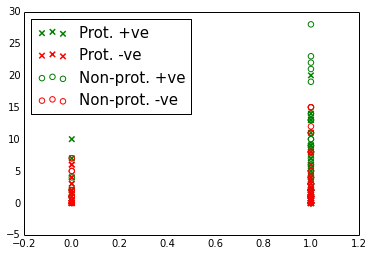

In [8]:
num_to_draw = 200 # we will only draw a small number of points to avoid clutter
x_draw = X[:num_to_draw]
y_draw = y[:num_to_draw]
x_control_draw = x_control['race'][:num_to_draw]

X_s_0 = x_draw[x_control_draw == 0.0]
X_s_1 = x_draw[x_control_draw == 1.0]
y_s_0 = y_draw[x_control_draw == 0.0]
y_s_1 = y_draw[x_control_draw == 1.0]
plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Prot. +ve")
plt.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Prot. -ve")
plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
plt.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")


plt.tick_params(axis='x', which='both', bottom='off', top='off') # dont need the ticks to see the data distribution
plt.tick_params(axis='y', which='both', left='off', right='off')
plt.legend(loc=2, fontsize=15)
plt.savefig("img/data.png")
plt.show()


In [9]:
compas_data[(compas_data.race == 'African-American') & (compas_data.two_year_recid == True)].shape
compas_data[(compas_data.race == 'Caucasian') & (compas_data.two_year_recid == False)].shape
compas_data[(compas_data.race == 'Caucasian')].shape

ut.compute_p_rule(x_control['race'], y)  # compute the p-rule i




Total data points: 6150
# non-protected examples: 3696
# protected examples: 2454
Non-protected in positive class: 1901 (51%)
Protected in positive class: 966 (39%)
P-rule is: 77%


76.53364784201855

In [10]:
X = ut.add_intercept(X) # add intercept to X before applying the linear classifier
 #the train test split needs keys in case there are several protected attributes

In [11]:
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)


In [12]:
loss_function = lf._logistic_loss
sensitive_attrs = ["race"]
gamma = None

sensitive_attrs_name = sensitive_attrs[0]

In [13]:
def train_test_classifier():
    w = ut.train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
    train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
    distances_boundary_test = (np.dot(x_test, w)).tolist()
    all_class_labels_assigned_test = np.sign(distances_boundary_test)
    correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
    cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
    p_rule = ut.print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0])	
    return w, p_rule, test_score

In [14]:
def accuracy_per_group(x, y, x_control, w):
    
    def predict(x):
        return(np.sign(np.dot(x, w)))
    
    def results_protected_group(group = 1):
        
        def results_prediction_category(prediction = 1):
            mask = np.array([i == prediction for i in predict(x_group)])
            correct = sum(predict(x_group[mask]) == y_group[mask])
            false = sum(mask) - correct
            return correct, false
        
        mask = np.array([i == group for i in x_control['race']])
        x_group = x[mask]
        y_group = y[mask]
        FP, TP = results_prediction_category(prediction = 1)
        FN, TN = results_prediction_category(prediction = -1)     
        return FP, TP, FN, TN
    
    FP1, TP1, FN1, TN1 = results_protected_group(1)
    FP0, TP0, FN0, TN0 = results_protected_group(0)
    
    return FP1, TP1, FN1, TN1, FP0, TP0, FN0, TN0
    

In [15]:
def bar_chart_accuracy_per_group(x, y, x_control, w, mode = 'positve-negative'):
    
    FP1, TP1, FN1, TN1, FP0, TP0, FN0, TN0 = accuracy_per_group(x, y, x_control, w) 
    
    N = 4
    if mode == 'true-false':
        a = (FN1, FP1, FN0, FP0)  #errors
        b = (TN1, TP1, TN0, TP0)  #correct
        
    if mode == 'positve-negative':
        a = (TN1, FP1, TN0, FP0)   #negative real label  
        b = (FN1, TP1, FN0, TP0)   #positive real label
    
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    plt.ylabel('Population')
    plt.title('Prediction accuracy by group and prediction')
    plt.xticks(ind, ('Black Low', 'Black High', 'White Low', 'White High'))
    plt.yticks(np.arange(0, max(a) + max(b) + 100, 200))
    
    if mode == 'true-false':
        p1 = plt.bar(ind, b, width, color='#d62728')
        p2 = plt.bar(ind, a, width, bottom = b)
        plt.legend((p1[0], p2[0]), ('Wrong Prediction', 'Accurate Prediction'), loc=(1.1,0.5))
        
    if mode == 'positve-negative':
        p1 = plt.bar(ind, b, width)
        p2 = plt.bar(ind, a, width, bottom = b, color='#d62728')        
        plt.legend((p1[0], p2[0]), ('Negative real label', 'Positive real label'), loc=(1.1,0.5))

    return(plt.show())
    
    
    

Accuracy: 0.67
Protected/non-protected in +ve class: 26% / 52%
P-rule achieved: 50%
Covariance between sensitive feature and decision from distance boundary : 0.129



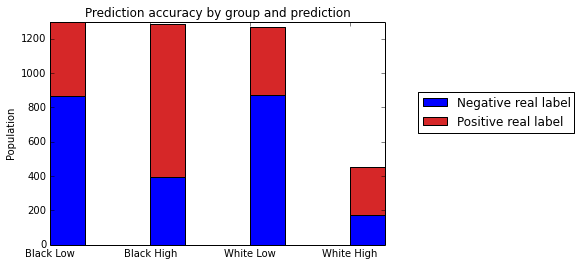

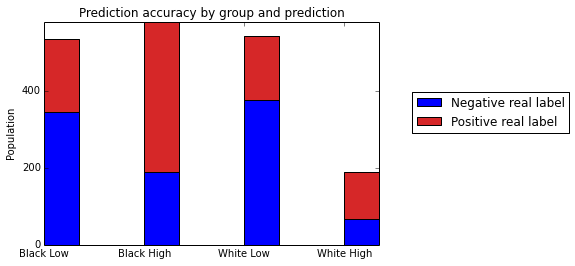

In [16]:
sensitive_attrs_to_cov_thresh = {}
apply_fairness_constraints = 0
apply_accuracy_constraint = 0
sep_constraint = 0
w, p, acc = train_test_classifier()

bar_chart_accuracy_per_group(x_train, y_train, x_control_train, w)
bar_chart_accuracy_per_group(x_test, y_test, x_control_test, w)

Accuracy: 0.53
Protected/non-protected in +ve class: 16% / 18%
P-rule achieved: 90%
Covariance between sensitive feature and decision from distance boundary : 0.001



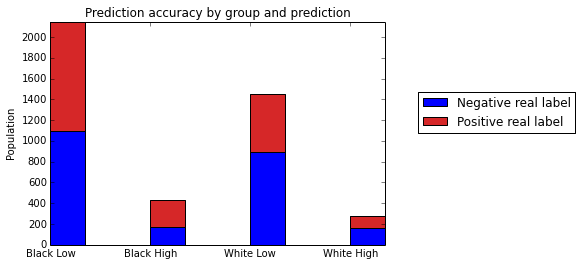

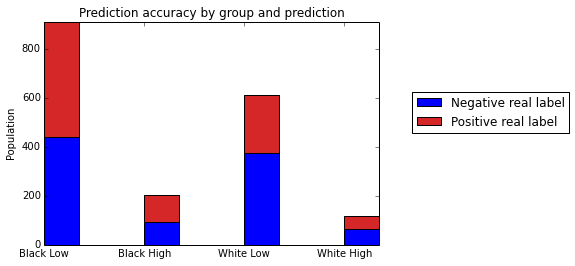

In [17]:
apply_fairness_constraints = 1
apply_accuracy_constraint = 0
sep_constraint = 0
threshold = 0
sensitive_attrs_to_cov_thresh = {sensitive_attrs_name: threshold}

w, p, acc = train_test_classifier()

bar_chart_accuracy_per_group(x_train, y_train, x_control_train, w)
bar_chart_accuracy_per_group(x_test, y_test, x_control_test, w)

Accuracy: 0.60
Protected/non-protected in +ve class: 10% / 24%
P-rule achieved: 41%
Covariance between sensitive feature and decision from distance boundary : 0.019



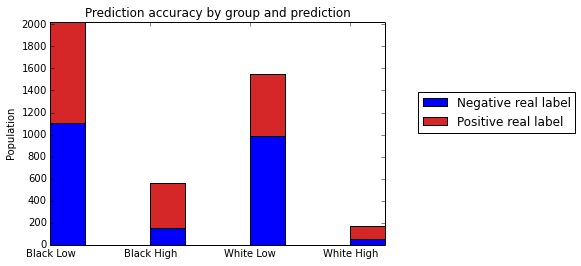

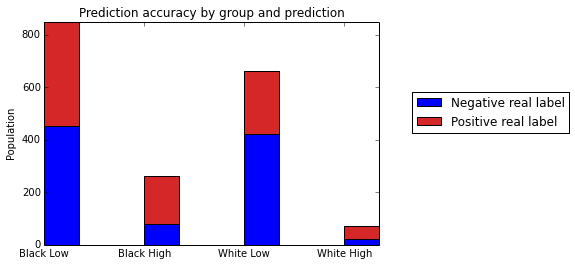

In [18]:
apply_fairness_constraints = 0
apply_accuracy_constraint = 1
sep_constraint = 0
gamma = 0.08

w, p, acc = train_test_classifier()

bar_chart_accuracy_per_group(x_train, y_train, x_control_train, w)
bar_chart_accuracy_per_group(x_test, y_test, x_control_test, w)

Accuracy: 0.66
Protected/non-protected in +ve class: 29% / 55%
P-rule achieved: 52%
Covariance between sensitive feature and decision from distance boundary : 0.125



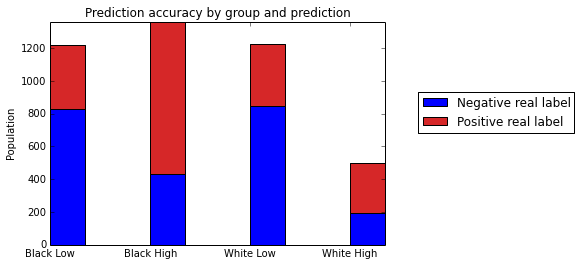

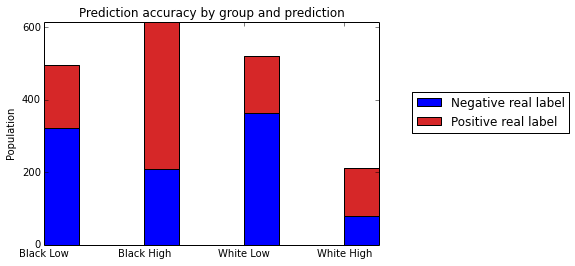

In [19]:
apply_fairness_constraints = 0
apply_accuracy_constraint = 1
sep_constraint = 1
gamma = 0.1
threshold = 0
sensitive_attrs_to_cov_thresh = {sensitive_attrs_name: threshold}

w, p, acc = train_test_classifier()

bar_chart_accuracy_per_group(x_train, y_train, x_control_train, w)
bar_chart_accuracy_per_group(x_test, y_test, x_control_test, w)